# MetaCalibration Demo

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import galsim

In [3]:
import ngmix

Code that implements parts of metacal:
 - [test_metacal.py](https://github.com/GalSim-developers/GalSim/blob/master/tests/test_metacal.py) in GalSim/tests/
 - [metacal.py](https://github.com/esheldon/ngmix/blob/master/ngmix/metacal.py) in esheldon/ngmix/
 - [metacal.py](https://github.com/emhuff/MetaCalibration/blob/master/Scripts/metacal.py) in emhuff/MetaCalibration/

In [4]:
help(ngmix.metacal.get_all_metacal)

Help on function get_all_metacal in module ngmix.metacal:

get_all_metacal(obs, step=0.01, fixnoise=True, cheatnoise=None, **kw)
    Get all combinations of metacal images in a dict
    
    parameters
    ----------
    obs: Observation, ObsList, or MultiBandObsList
        The values in the dict correspond to these
    step: float, optional
        The shear step value to use for metacal.  Default 0.01
    psf: string, optional
        PSF to use for metacal. Default is a dilated version
        of the original psf, but you can also set psf to
    
            'gauss': reconvolve gaussian that is larger than
                     the original and round.
            'fitgauss': fit a gaussian to the PSF and make
                        use round, dilated version for reconvolution
    
    types: list, optional
        If psf='gauss' or 'fitgauss', then the default set is the minimal
        set ['noshear','1p','1m','2p','2m']
    
        Otherwise, the default is the full possible set

## Huff Code

In [2]:
import galsim
import math
import numpy as np

pad_factor = 8

def getTargetPSF(psfImage, pixelscale, g1 =0.0, g2 = 0.0, gal_shear=True):
    pixel = galsim.Pixel(pixelscale)

    psf = galsim.InterpolatedImage(psfImage, pad_factor=pad_factor )

    # Deconvolve the pixel from the PSF.
    pixInv = galsim.Deconvolve(pixel)
    psfNoPixel = galsim.Convolve([psf , pixInv])

    # Increase the size of the PSF by 2*shear
    psfGrownNoPixel = psfNoPixel.dilate(1 + 2*math.sqrt(g1**2 + g2**2))

    # Convolve the grown psf with the pixel
    psfGrown = galsim.Convolve([psfGrownNoPixel,pixel])
    
    # I think it's actually the shear of the effective, PSF-convolved PSF that we're sensitive
    # to. So I'm going to shear at this stage if gal_shear is False.
    if not gal_shear:
        psfGrown = psfGrown.shear(g1=g1, g2=g2)
    
    return psfGrown


def getMetaCalNoiseCorrImage(galaxyImage, psf, psfTarget, g1=0.0, g2=0.0, variance = None):
    
    psfInv = galsim.Deconvolve(psf)
    CN = galsim.UncorrelatedNoise(variance=variance, rng=galsim.BaseDeviate, wcs = galaxyImage.wcs)
    #print "reported noise before metacal is: ",np.sqrt(CN.getVariance())
    CN = CN.convolvedWith(psfInv)
    CN = CN.shear(g1 = g1, g2 = g2)
    CN = CN.convolvedWith(psfTarget)
    #print "reported noise after metacal is: ",np.sqrt(CN.getVariance())
    noiseCorr = CN.drawImage(image=galaxyImage.copy(),add_to_image=False)
    return CN

def deCorrelateNoiseObject(galaxyImage, psf, psfTarget, g1=0.0, g2=0.0, variance = None, image_size = 256):
    # First, generate a blank image with the right initial noise field.
    noiseImageFull = galsim.Image(image_size,image_size,scale=galaxyImage.scale)
    whiteNoise = galsim.UncorrelatedNoise(variance=variance,rng=galsim.BaseDeviate(), wcs = galaxyImage.wcs)
    noiseImageFull.addNoise(whiteNoise)
    # Next, apply metaCal to this image
    noiseImageSheared = metaCalibrateReconvolve(noiseImageFull, psf, psfTarget, g1=g1, g2=g2, noise_symm = False, variance = variance)
    # Find the difference image, representing the correlated noise.
    noiseImageDiff = (  noiseImageSheared - noiseImageFull )
    # create a correlated noise objecting representing this noise.
    deCorrCNObj = galsim.CorrelatedNoise(noiseImageDiff,rng=galsim.BaseDeviate())
    return deCorrCNObj


def metaCalibrateReconvolve(galaxyImage, psf, psfTarget, g1=0.0, g2=0.0, noise_symm = False, variance = None, regularize= False):

    gspars = galsim.GSParams()
    image_size  = galaxyImage.array.shape[0]
    gspars.noise_pad_factor = 4*image_size
    gspars.pad_factor = 1
    gspars.noise_pad = variance
    
    
    galaxy = galsim.InterpolatedImage(galaxyImage,gsparams=gspars)
    
    if variance is not None:
        galaxy.noise = galsim.UncorrelatedNoise(variance=variance,wcs=galaxyImage.wcs)
    psfInv = galsim.Deconvolve(psf)
    galaxy_noPSF = galsim.Convolve([galaxy,psfInv])

    # Apply a shear
    galaxy_noPSF = galaxy_noPSF.lens( g1, g2,1.0)

    # Reconvolve to the target psf
    galaxy_sheared_reconv = galsim.Convolve([galaxy_noPSF, psfTarget])
    
    
    # Draw reconvolved, sheared image to an ImageD object.
    galaxyImageSheared = galaxy_sheared_reconv.drawImage(image=galaxyImage.copy(),method='no_pixel')
    
    if regularize is True:
        # apply Bernstein's k-sigma filter.
        imFFT = np.fft.fft2(galaxyImageSheared.array)
        ky = np.fft.fftfreq(galaxyImageSheared.array.shape[0])
        kyy = np.outer(ky,np.ones(galaxyImageSheared.array.shape[1]))
        kx =  np.fft.fftfreq(galaxyImageSheared.array.shape[1])
        kxx = np.outer(np.ones(galaxyImageSheared.array.shape[0]),kx)
        kk = np.sqrt(kxx**2 + kyy**2)
        scale = (2./galaxyImage.scale)
        Nfilt = 4
        outer = kk >= np.sqrt(2*Nfilt)/scale
        W = (1 - (kk*scale)**2/(2*Nfilt))**Nfilt
        W[outer] =0.
        imFFT = imFFT * W
        arrFilt = np.ascontiguousarray(np.real(np.fft.ifft2(imFFT)))
        imFilt = galsim.Image(arrFilt,scale=galaxyImageSheared.scale)
        imFilt.addNoise(galsim.UncorrelatedNoise(variance=variance),wcs=galaxyImage.wcs)
        imFilt.noise = galsim.UncorrelatedNoise(variance=variance,wcs=galaxyImage.wcs)
        return imFilt
        
    
    if noise_symm is True:
        #deCorrNoiseObj = deCorrelateNoiseObject(galaxyImage, psf, psfTarget, g1=g1, g2=g2,variance = variance)
        #galaxyImageSheared.addNoise(deCorrNoiseObj)
        galaxyImageSheared.symmetrizeNoise(galaxy_sheared_reconv.noise, order=4)

    return galaxyImageSheared
        

        
def metaCalibrate(galaxyImage, psfImage, g1 = 0.00, g2 = 0.00, gal_shear = True, noise_symm = False, variance = None,
                  psfObj = None, targetPSFObj = None):
    """The new gal_shear argument tells metaCalibrate whether to interpret the (g1, g2) args as a
    shear to apply to the *galaxy* (True - which is the default behavior and the only behavior this
    function had before) or to the *PSF* (False - in which case the galaxy is unsheared but the PSF
    is sheared, in addition to being enlarged by the usual amount)."""

    # Routine to drive the metaCalibration procedure.
    pixelscale = psfImage.scale
    
    # First, work out the target psf, which changes depending on whether we're shearing the galaxy
    # or PSF.
    if psfObj is None:
        psf = galsim.InterpolatedImage(psfImage)

    if targetPSFObj is None:
        targetPSFObj = getTargetPSF(psfImage, pixelscale, g1 =g1, g2 = g2, gal_shear=gal_shear)

    else:
        psf = psfObj
    
    if gal_shear:
        # Then, produce the reconvolved images, with and without shear.
        reconvSheared = metaCalibrateReconvolve(
            galaxyImage, psf, targetPSFObj, galaxyImage.copy(), g1=g1, g2=g2,
            noise_symm = noise_symm, variance = variance)
        reconvUnsheared = metaCalibrateReconvolve(
            galaxyImage, psf, targetPSFObj, galaxyImage.copy(), g1=0.0, g2=0.0,
            noise_symm = noise_symm, variance = variance)
        return reconvSheared, reconvUnsheared, targetPSFImage
    else:
        # We really only have to produce one image since the galaxy isn't sheared.
        reconvUnsheared = \
            metaCalibrateReconvolve(galaxyImage, psf, targetPSFObj, g1=0.0, g2=0.0,
            noise_symm = noise_symm, variance = variance)
        return reconvUnsheared, reconvUnsheared, targetPSFImage

## Simulated Data

In [204]:
def simulate(hlr=1.0, galaxy_shape=galsim.Shear(q=0.5,  beta=30 * galsim.degrees),
             fwhm=1.0, psf_shape=galsim.Shear(g1=0, g2=0),
             snr=50., scale=0.2, size=48, rng=None):
    psf = galsim.Moffat(flux=1., fwhm=fwhm, beta=3.5).shear(psf_shape)
    psf_image = psf.drawImage(scale=scale, nx=size, ny=size)
    gal = galsim.Gaussian(flux=1000., half_light_radius=hlr).shear(galaxy_shape)
    src = galsim.Convolve([gal, psf])
    src_image = src.drawImage(scale=scale, nx=size, ny=size)
    src_image.addNoiseSNR(galsim.GaussianNoise(rng=rng), snr=snr, preserve_flux=False)
    return src_image, psf_image

In [205]:
def draw(image, ax=None, colorbar=True):
    ax = ax or plt.gca()
    data = image.array
    ny, nx = data.shape
    s = image.scale
    I = ax.imshow(image.array, interpolation='none', origin='lower', aspect=1.,
                  extent=[-0.5 * nx * s, 0.5 * nx * s, -0.5 * ny * s, 0.5 * ny * s])
    ax.axis('off')
    if colorbar:
        plt.colorbar(I, ax=ax).set_label('Flux')

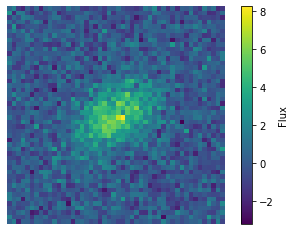

In [213]:
rng = galsim.BaseDeviate(1)
src, psf = simulate(rng=rng)
draw(src)

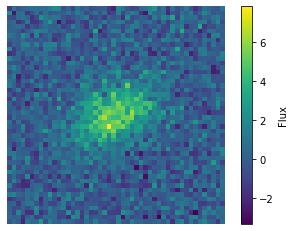

In [214]:
rng = galsim.BaseDeviate(2)
src, psf = simulate(rng=rng)
draw(src)

## Shear Estimators

In [95]:
def measure(obs):
    src = galsim.Image(obs.image)
    psf = galsim.Image(obs.psf.image)
    try:
        result = galsim.hsm.EstimateShear(src, psf)
        return np.array([result.corrected_e1, result.corrected_e2])
    except RuntimeError as e:
        print(e)
        return np.array([np.inf, np.inf])

## Counter-Factual Images

In [234]:
def counterfactual(src, psf, gmag=0.01, fixnoise=False, **kwargs):
    psf_obs = ngmix.Observation(psf.array)
    obs = ngmix.Observation(src.array, psf=psf_obs)
    obsdict = ngmix.metacal.get_all_metacal(obs, step=gmag, fixnoise=fixnoise, **kwargs)
    obsdict['input'] = obs
    return obsdict

In [253]:
def plot_counterfactual(snr=200, fwhm=1.0, hlr=1.0, e1=0.3, e2=0.5, gmag=0.02, fixnoise=True, seed=123, save=None):
    
    true_shape=galsim.Shear(e1=e1, e2=e2)
    rng = galsim.BaseDeviate(seed)
    src_in, psf_in = simulate(snr=snr, fwhm=fwhm, hlr=hlr, galaxy_shape=true_shape, rng=rng)
    labels = dict(
        fwhm= f'FWHM={fwhm:.1f}"',
        hlr=f'HLR={hlr:.1f}"',
        snr=f'SNR={snr:.1f}',
        shape=f'$e_1={true_shape.e1:+.3f},e_1={true_shape.e2:+.3f}$',
        g1=f'$g_1=+{gmag:.3f}$',
        g2=f'$g_2=+{gmag:.3f}$',
        gamma=f'$1+2|\gamma|={1+2*gmag:.3f}$',
    )
    fixnoise_rng = np.random.RandomState(seed)
    obslist = counterfactual(src_in, psf_in, gmag=gmag, fixnoise=fixnoise, rng=fixnoise_rng,
                             types=['noshear','1p','2p', '1p_psf', '2p_psf'])

    fig, axes = plt.subplots(3, 4, figsize=(12, 9))
    plt.subplots_adjust(hspace=0.02, wspace=0.02, left=0, right=1, top=1, bottom=0)
    
    def show(ax, obs, upper_text, lower_text=None):
        ax.imshow(obs.image, interpolation='none', origin='lower', aspect='auto')
        ax.axis('off')
        kwopts = dict(transform=ax.transAxes, color='w',
                      verticalalignment='center', horizontalalignment='center')
        if upper_text is not None:
            ax.text(0.5, 0.9, upper_text, fontsize=20, **kwopts)
        if lower_text is not None:
            ax.text(0.5, 0.1, lower_text, fontsize=16, **kwopts)

    show(axes[0, 0], obslist['input'].psf, '$P$', labels.get('fwhm'))
    show(axes[0, 1], obslist['noshear'].psf, '$\Gamma(0)$', labels.get('gamma'))
    show(axes[0, 2], obslist['1p_psf'].psf, '$\Gamma(g_1)$', labels.get('g1'))
    show(axes[0, 3], obslist['2p_psf'].psf, '$\Gamma(g_2)$', labels.get('g2'))

    show(axes[1, 0], obslist['input'], r'$G(0) \times P$', labels.get('snr'))
    show(axes[1, 1], obslist['noshear'], r'$G(0) \times \Gamma(0)$', labels.get('hlr'))
    show(axes[1, 2], obslist['1p'], r'$G(g_1) \times \Gamma(0)$', labels.get('g1'))
    show(axes[1, 3], obslist['2p'], r'$G(g_2) \times \Gamma(0)$', labels.get('g2'))

    axes[2, 0].axis('off')
    axes[2, 1].axis('off')
    show(axes[2, 2], obslist['1p_psf'], r'$G(0) \times \Gamma(g_1)$', labels.get('g1'))
    show(axes[2, 3], obslist['2p_psf'], r'$G(0) \times \Gamma(g_2)$', labels.get('g2'))
    
    if save:
        plt.savefig(save)

**TODO:**
 - Superimpose HSM ellipses
 - Replace 1+2|gamma| with ??

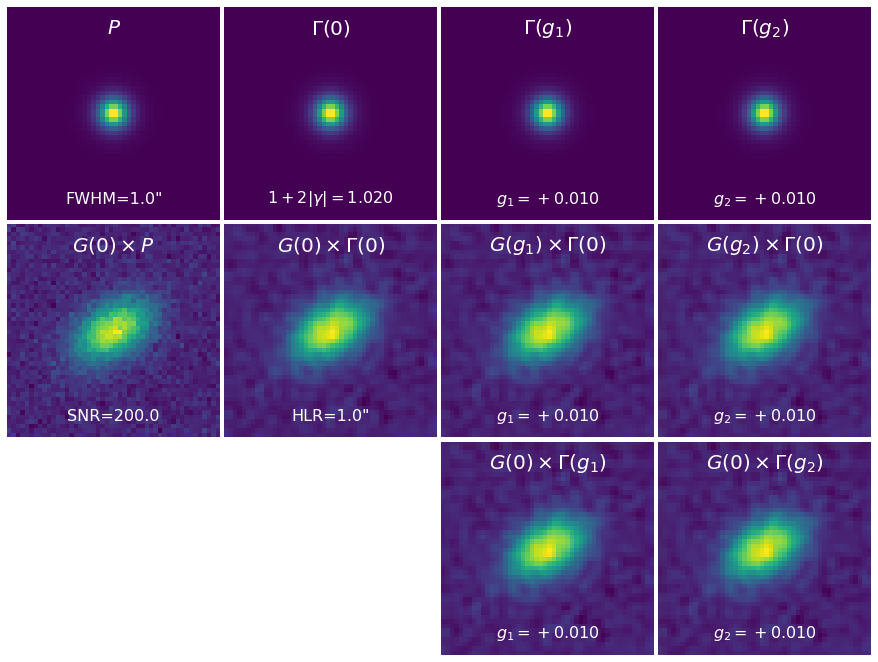

In [269]:
plot_counterfactual(snr=200, gmag=0.01, seed=1)

## Responsivity Estimates for a Single Galaxy

In [293]:
def metastudy_one(snr=200, fwhm=1.0, hlr=1.0, e1=0.3, e2=0.5, gmag=0.02, fixnoise=True,
                  shearpsf=False, seed=123, multipliers=[0.5, 1, 1.5, 2], nstudy=100):

    true_shape=galsim.Shear(e1=e1, e2=e2)
    rng = galsim.BaseDeviate(seed)
    src_in, psf_in = simulate(snr=snr, fwhm=fwhm, hlr=hlr, galaxy_shape=true_shape, rng=rng)
    
    if shearpsf:
        types = ['noshear','1p_psf','1m_psf','2p_psf', '2m_psf']
        suffix = '_psf'
    else:
        types = ['noshear','1p','1m','2p', '2m']
        suffix = ''
    fixnoise_rng = np.random.RandomState(seed)
    
    gvec = gmag * np.array(multipliers)
    ng = len(gvec)
    evec = np.empty((2, 2, 2 * ng + 1))
    for j, g in enumerate(gvec):
        obslist = counterfactual(src_in, psf_in, gmag=g, fixnoise=fixnoise, types=types, rng=fixnoise_rng)
        evec[:, 0, ng] = measure(obslist['noshear'])
        evec[:, 1, ng] = evec[:, 0, ng]
        evec[:, 0, ng + j + 1] = measure(obslist[f'1p{suffix}'])
        evec[:, 1, ng + j + 1] = measure(obslist[f'2p{suffix}'])
        evec[:, 0, ng - j - 1] = measure(obslist[f'1m{suffix}'])
        evec[:, 1, ng - j - 1] = measure(obslist[f'2m{suffix}'])
    evec -= np.array([e1, e2]).reshape(2, 1, 1)
    
    R = np.empty((2, 2, nstudy))
    for k in range(nstudy):
        if k > 0:
            src_in, psf_in = simulate(snr=snr, fwhm=fwhm, hlr=hlr, galaxy_shape=true_shape, rng=rng)
        obslist = counterfactual(src_in, psf_in, gmag=gmag, fixnoise=fixnoise, types=types, rng=fixnoise_rng)
        e1p = measure(obslist[f'1p{suffix}'])
        e1m = measure(obslist[f'1m{suffix}'])
        e2p = measure(obslist[f'2p{suffix}'])
        e2m = measure(obslist[f'2m{suffix}'])
        R[0, :, k] = (e1p - e1m) / (2 * gmag)
        R[1, :, k] = (e2p - e2m) / (2 * gmag)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    gvec = np.hstack((-gvec[::-1], [0,], gvec))
    ax = axes[0]
    ax.plot(gvec, evec[0, 0], 'r.-', label='$\delta e_1(g_1)$')
    ax.plot(gvec, evec[0, 1], 'r.--', label='$\delta e_1(g_2)$')
    ax.plot(gvec, evec[1, 0], 'b.--', label='$\delta e_2(g_1)$')
    ax.plot(gvec, evec[1, 1], 'b.-', label='$\delta e_2(g_2)$')
    ax.set_xlabel('Applied shear $g_{1,2}$', fontsize='large')
    ax.set_ylabel('Measured shape change $\delta e_{1,2}$', fontsize='large')
    ax.grid()
    ax.legend(ncol=2, fontsize='large')
    
    bad = np.isinf(R)
    bins = np.linspace(*np.percentile(R[~bad], (0, 100)), 50)
    def plothist(Rvals, label, color, ls, ax):
        bad = np.isinf(Rvals)
        if np.any(bad):
            print(f'{np.count_nonzero(bad)} / {len(bad)} bad HSM fits for "{label}".')
        ax.hist(Rvals[~bad], bins=bins, color=color, ls=ls, label=label, histtype='step')

    ax = axes[1]
    plothist(R[0, 0], '$\partial e_1 / \partial g_1$', 'r', '-', ax)
    plothist(R[0, 1], '$\partial e_1 / \partial g_2$', 'r', '--', ax)
    plothist(R[1, 0], '$\partial e_2 / \partial g_1$', 'b', '--', ax)
    plothist(R[1, 1], '$\partial e_2 / \partial g_2$', 'b', '-', ax)
    ax.legend(ncol=2, fontsize='large')
    ax.set_xlabel('Shear Responsivity')
    ax.set_yticks([])

CPU times: user 40.3 s, sys: 1.57 s, total: 41.9 s
Wall time: 41.9 s


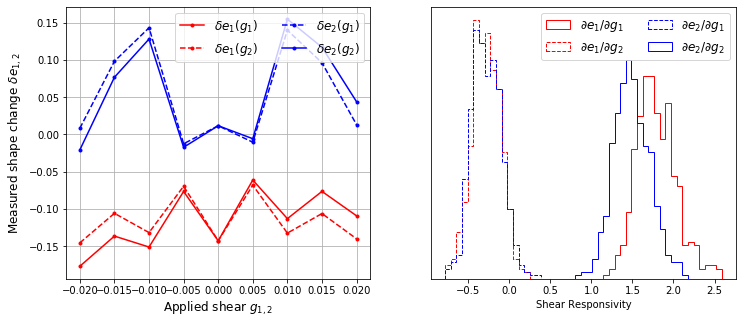

In [288]:
%time metastudy_one(snr=50, gmag=0.01, fixnoise=True, seed=1, nstudy=500)

Error: too many iterations in adaptive moments

Error: too many iterations in adaptive moments

1 / 500 bad HSM fits for "$\partial e_1 / \partial g_1$".
1 / 500 bad HSM fits for "$\partial e_1 / \partial g_2$".
1 / 500 bad HSM fits for "$\partial e_2 / \partial g_1$".
1 / 500 bad HSM fits for "$\partial e_2 / \partial g_2$".


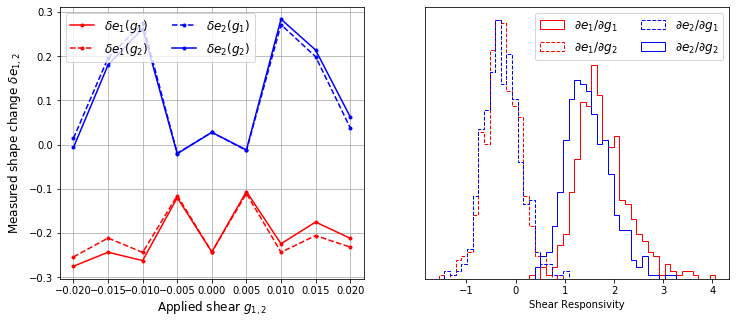

In [294]:
metastudy_one(snr=25, gmag=0.01, fixnoise=True, seed=1, nstudy=500)

## Sandbox

Terminology:
 - $G(x)$ is the galaxy profile above the atmosphere.
 - $I(x) = G(x)\ast P(x)$ is the observed image.
 - $P(x)$ is the PSF, including the atmosphere, instrument and pixel response.
 - $s_g$ applies a reduced shear $g = (g_1, g_2)$.
 - $I'(x\mid g)$ is the "counterfactual" image that would have been observed if a shear $g$ was applied to the galaxy before convolving with the PSF, $I' = P\ast (s_g G)$.
 - $\Gamma(x)$ is the "target" PSF dilated by a factor $1 + 2|\gamma|$ to ensure that noise in $I$ is not amplified when constructing $I'$.

Calculate a counterfactual image $I'$ from a source image $I$ and a PSF model
$$
I'(k\mid g) = \Gamma(k)^\ast s_g\left( \frac{I(k)}{P(k)^\ast} \right) \; ,
$$
where $g = (g_1, g_2)$ is the applied shear and $\Gamma$ is an image of the dilated PSF model:
$$
\Gamma(k) = I\left(\frac{k}{1 + 2\gamma}\right) \; ,
$$
with
$$
\gamma = \sqrt{g_1^2 + g_2^2} \; .
$$

In [113]:
def counterfactual(src_image, psf_image, gmag=0.4):

    # Initialize FFT parameters to use.
    gspars = galsim.GSParams()
    image_size = src_image.array.shape[0]
    gspars.noise_pad_factor = 4 * image_size
    gspars.pad_factor = 1
    gspars.noise_pad = None
    
    # Build interpolated models of the PSF and source.
    psf_model = galsim.InterpolatedImage(psf_image, pad_factor=8)
    src_model = galsim.InterpolatedImage(src_image, gsparams=gspars)

    # Deconvolve the PSF to estimate the galaxy model.
    psf_inverse = galsim.Deconvolve(psf_model)
    gal_model = galsim.Convolve([src_model, psf_inverse])
    
    # Create the (unsheared) target PSF model.
    pixel_model = galsim.Pixel(src_image.scale)
    pixel_inverse = galsim.Deconvolve(pixel_model)
    psf_no_pixel = galsim.Convolve([psf_model, pixel_inverse])
    psf_dilated_no_pixel = psf_no_pixel.dilate(1 + 2 * gmag)
    psf_target_model = galsim.Convolve([psf_dilated_no_pixel, pixel_model])
    
    # Galaxy model 0 is unsheared.
    src_deconvolved = [gal_model]
    # Target PSF models 0-4 are unsheared.
    psf_out_model = [psf_target_model] * 5
    # Loop over shears to apply.
    for (g1, g2) in ((+gmag, 0), (-gmag, 0), (0, +gmag), (0, -gmag)):
        # Counterfactual galaxy models 1-4 are sheared.
        src_deconvolved.append(gal_model.lens(g1, g2, 1.))
        # Target PSF models 5-8 are sheared.
        psf_out_model.append(psf_out_model[0].shear(g1=g1, g2=g2))
    # Galaxy models 5-8 are unsheared.
    src_deconvolved.extend([gal_model] * 4)

    # Convolve each (galaxy, target PSF) pair to build a counterfactual image model.
    src_out_model = [galsim.Convolve([src, psf])
                     for (src, psf) in zip(src_deconvolved, psf_out_model)]
    
    # Render each PSF model (TODO: eliminate duplicates)
    psf_out = [psf_model.drawImage(psf_image.copy(), method='no_pixel')
               for psf_model in psf_out_model]
    # Render each counterfactual image (TODO: eliminate duplicates)
    src_out = [src_model.drawImage(src_image.copy(), method='no_pixel')
               for src_model in src_out_model]
    
    return src_out, psf_out

In [142]:
def plot_counterfactual(src_in, psf_in, src_out, psf_out, labels={}):

    fig, axes = plt.subplots(3, 4, figsize=(12, 9))
    plt.subplots_adjust(hspace=0.02, wspace=0.02, left=0, right=1, top=1, bottom=0)
    
    def show(ax, img, upper_text, lower_text=None):
        ax.imshow(img.array, interpolation='none', origin='lower', aspect='auto')
        ax.axis('off')
        kwopts = dict(transform=ax.transAxes, color='w',
                      verticalalignment='center', horizontalalignment='center')
        if upper_text is not None:
            ax.text(0.5, 0.9, upper_text, fontsize=20, **kwopts)
        if lower_text is not None:
            ax.text(0.5, 0.1, lower_text, fontsize=16, **kwopts)

    show(axes[0, 0], psf_in, '$P$', labels.get('fwhm'))
    show(axes[0, 1], psf_out[0], '$\Gamma(0)$', labels.get('gamma'))
    show(axes[0, 2], psf_out[5], '$\Gamma(g_1)$', labels.get('g1'))
    show(axes[0, 3], psf_out[7], '$\Gamma(g_2)$', labels.get('g2'))

    show(axes[1, 0], src_in, r'$G(0) \times P$', labels.get('snr'))
    show(axes[1, 1], src_out[0], r'$G(0) \times \Gamma(0)$', labels.get('hlr'))
    show(axes[1, 2], src_out[1], r'$G(g_1) \times \Gamma(0)$', labels.get('g1'))
    show(axes[1, 3], src_out[3], r'$G(g_2) \times \Gamma(0)$', labels.get('g2'))

    #show(axes[2, 0], src_in, r'$G(0) \times P$')
    #show(axes[2, 1], src_out[0], r'$G(0) \times \Gamma(0)$')
    show(axes[2, 2], src_out[5], r'$G(0) \times \Gamma(g_1)$', labels.get('g1'))
    show(axes[2, 3], src_out[7], r'$G(0) \times \Gamma(g_2)$', labels.get('g2'))
    
    return axes

In [143]:
def metastudy(snr = 200, fwhm = 1.0, hlr = 1.0, e1=0.3, e2=0.5, gmag = 0.02, multipliers=[0.5, 1, 1.5, 2]):

    true_shape=galsim.Shear(e1=e1, e2=e2)
    src_in, psf_in = simulate(snr=snr, fwhm=fwhm, hlr=hlr, galaxy_shape=true_shape)
    
    gvec = gmag * np.array(multipliers)
    ng = len(gvec)
    evec = np.empty((2, 2 * ng + 1, 4))
    for j, g in enumerate(gvec):
        src_out, psf_out = counterfactual(src_in, psf_in, gmag=g)
        if j == 0:
            evec[:, ng, :] = measure(src_out[0], psf_out[0]).reshape(2, 1)
        i = j + 1
        evec[:, ng + i, 0] = measure(src_out[1], psf_out[1])
        evec[:, ng - i, 0] = measure(src_out[2], psf_out[2])
        evec[:, ng + i, 1] = measure(src_out[3], psf_out[3])
        evec[:, ng - i, 1] = measure(src_out[4], psf_out[4])
        evec[:, ng + i, 2] = measure(src_out[5], psf_out[5])
        evec[:, ng - i, 2] = measure(src_out[6], psf_out[6])
        evec[:, ng + i, 3] = measure(src_out[7], psf_out[7])
        evec[:, ng - i, 3] = measure(src_out[8], psf_out[8])
    evec -= np.array([e1, e2]).reshape(2, 1, 1)
        
    labels = dict(
        fwhm= f'FWHM={fwhm:.1f}"',
        hlr=f'HLR={hlr:.1f}"',
        snr=f'SNR={snr:.1f}',
        shape=f'$e_1={true_shape.e1:+.3f},e_1={true_shape.e2:+.3f}$',
        g1=f'$g_1=+{gvec[-1]:.3f}$',
        g2=f'$g_2=+{gvec[-1]:.3f}$',
        gamma=f'$1+2|\gamma|={1+2*gvec[-1]:.3f}$',
    )
    axes = plot_counterfactual(src_in, psf_in, src_out, psf_out, labels)

    gvec = np.hstack((-gvec[::-1], [0,], gvec))
    axes[2, 0].plot(gvec, evec[0, :, 0], '.-', label='$\delta e_1(g_1)$')
    axes[2, 0].plot(gvec, evec[0, :, 1], '--', label='$\delta e_1(g_2)$')
    axes[2, 0].plot(gvec, evec[1, :, 0], '--', label='$\delta e_2(g_1)$')
    axes[2, 0].plot(gvec, evec[1, :, 1], '.-', label='$\delta e_2(g_2)$')
    axes[2, 0].legend(ncol=2)
    
    axes[2, 1].plot(gvec, evec[0, :, 2], '.-', label='$\delta e_1(p_1)$')
    axes[2, 1].plot(gvec, evec[0, :, 3], '--', label='$\delta e_1(p_2)$')
    axes[2, 1].plot(gvec, evec[1, :, 2], '--', label='$\delta e_2(p_1)$')
    axes[2, 1].plot(gvec, evec[1, :, 3], '.-', label='$\delta e_2(p_2)$')
    axes[2, 1].legend(ncol=2)

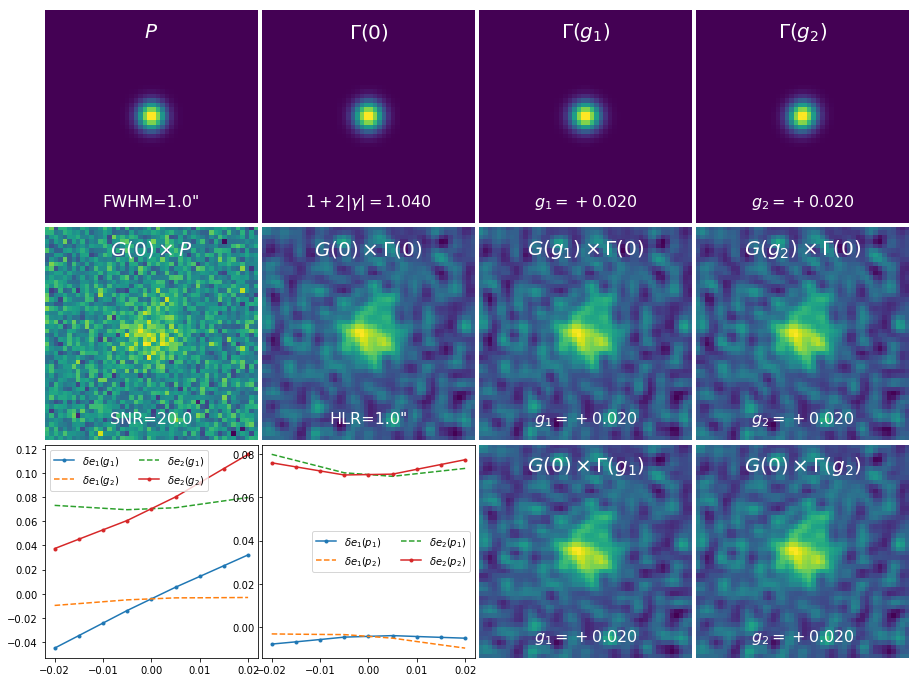

In [152]:
metastudy(snr=20, gmag=0.01, e1=0.0, e2=0.0)

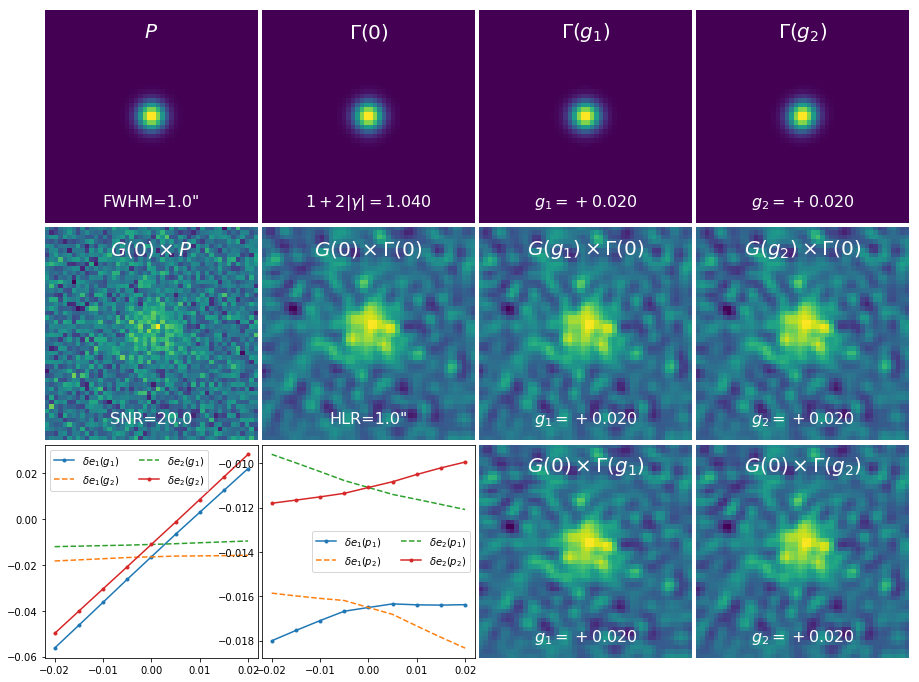

In [153]:
metastudy(snr=20, gmag=0.01, e1=0.0, e2=0.0)

TODO:
 - Implement alternate shape estimator (KSB?)
 - How to handle when HSM fails?
 - How are G(0) x G(g1) images used?  Need similar procedure for PSF size?
 - Implement more realistic galaxy models.